In [1]:
import tensorflow
import numpy
import transformers
import datasets

## STEP 1. NSMC 데이터 분석 및 Huggingface dataset 구성

In [2]:
import datasets
from datasets import load_dataset


huggingface_nsmc_dataset = load_dataset("Blpeng/nsmc")
print(huggingface_nsmc_dataset)

Using custom data configuration Blpeng___nsmc-55757a98c8abea78


  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.19M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /aiffel/.cache/huggingface/datasets/csv/Blpeng___nsmc-55757a98c8abea78/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'id', 'document', 'label'],
        num_rows: 400000
    })
})


In [3]:
import pandas as pd

df = nsmc_dataset['train'].to_pandas()
df.head()

NameError: name 'nsmc_dataset' is not defined

In [ ]:
df.info()

In [ ]:
print(df.duplicated(subset=['document']).sum())

### 데이터의 수가 이상한 걸 발견 증강된 데이터를 사용중이였던 것을 확인 후 수정

In [2]:
import datasets
from datasets import load_dataset


nsmc_dataset = load_dataset("e9t/nsmc")
print(nsmc_dataset)

Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/e9t___nsmc)/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


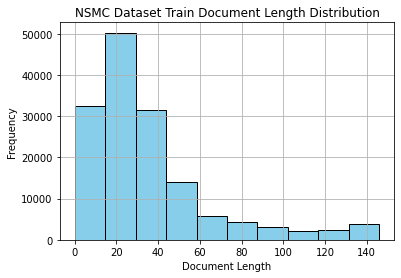

In [3]:
import matplotlib.pyplot as plt

# NSMC 데이터셋의 'document' 문자열 길이 리스트 생성
document_lengths = [len(item['document']) for item in nsmc_dataset['train']]

# 히스토그램 그리기
plt.hist(document_lengths, bins=10, color='skyblue', edgecolor='black')
plt.title('NSMC Dataset Train Document Length Distribution')
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## STEP 2. klue/bert-base model 및 tokenizer 불러오기

### 모델,토큰 불러오기

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base",num_labels=2 )
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

### 토큰화

In [5]:
def transform(data):
    return tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        max_length = 60,
        return_token_type_ids = False,
    )

In [6]:
hf_train_dataset = nsmc_dataset['train'].map(transform,batched=True)

  0%|          | 0/150 [00:00<?, ?ba/s]

In [7]:
hf_test_dataset = nsmc_dataset['test'].map(transform,batched=True)

  0%|          | 0/50 [00:00<?, ?ba/s]

In [8]:
hf_train_dataset[1]

{'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'label': 1,
 'input_ids': [2,
  1963,
  18,
  18,
  18,
  11811,
  2178,
  2088,
  28883,
  16516,
  2776,
  18,
  18,
  18,
  18,
  10737,
  2156,
  2015,
  2446,
  2232,
  6758,
  2118,
  1380,
  6074,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'id': '3819312',
 'document': '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나'}

## STEP 3. 위에서 불러온 tokenizer으로 데이터셋을 전처리하고, model 학습 진행해 보기


In [9]:
from datasets import DatasetDict

split_datasets = hf_train_dataset.train_test_split(test_size=0.1, seed=42)

hf_train_dataset = split_datasets['train']

hf_val_dataset = split_datasets['test']

### 하이퍼 파라미터 설정, 평가지표 설정

In [10]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments

output_dir = os.getenv('HOME')+'/aiffel/transformers'

training_arguments = TrainingArguments(
    output_dir,                             # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 256,   # 각 device 당 batch size
    per_device_eval_batch_size = 256,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

In [11]:
from datasets import load_metric
metric = load_metric('accuracy')

def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

### 모델 학습

In [12]:
trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()


The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 135000
  Num Epochs = 3
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 1584


Epoch,Training Loss,Validation Loss,Accuracy
1,0.296800,0.245483,0.897467
2,0.222700,0.239114,0.902267
3,0.187000,0.245629,0.904267


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 256
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 256
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint

TrainOutput(global_step=1584, training_loss=0.23263747041875665, metrics={'train_runtime': 4014.8919, 'train_samples_per_second': 100.874, 'train_steps_per_second': 0.395, 'total_flos': 1.2487497354e+16, 'train_loss': 0.23263747041875665, 'epoch': 3.0})

### 훈련,평가 로스 시각화 함수

In [16]:
import matplotlib.pyplot as plt
from typing import List, Dict, Union

def plot_loss_history(log_history: List[Dict[str, Union[float, int]]]):
    """
    Hugging Face Trainer의 log_history를 바탕으로 훈련 손실과 평가 손실 그래프를 그립니다.

    Args:
        log_history (List[Dict[str, Union[float, int]]]):
            trainer.state.log_history에서 얻은 로그 엔트리 리스트입니다.
            각 딕셔너리에는 'loss' (훈련 손실) 및/또는 'eval_loss' (평가 손실)와
            'epoch' 또는 'step' 정보가 포함될 수 있습니다.
    """
    train_losses = []
    eval_losses = []
    train_epochs_or_steps = []
    eval_epochs_or_steps = []

    for log_entry in log_history:
        if "loss" in log_entry:
            train_losses.append(log_entry["loss"])
            if "epoch" in log_entry:
                train_epochs_or_steps.append(log_entry["epoch"])
            elif "step" in log_entry:
                train_epochs_or_steps.append(log_entry["step"])
            else:
                train_epochs_or_steps.append(len(train_epochs_or_steps) + 1)

        if "eval_loss" in log_entry:
            eval_losses.append(log_entry["eval_loss"])
            if "epoch" in log_entry:
                eval_epochs_or_steps.append(log_entry["epoch"])
            elif "step" in log_entry:
                eval_epochs_or_steps.append(log_entry["step"])
            else:
                eval_epochs_or_steps.append(len(eval_epochs_or_steps) + 1)

    # 그래프 그리기
    plt.figure(figsize=(10, 6))

    if train_losses:
        plt.plot(train_epochs_or_steps, train_losses, label='Train Loss', marker='o', markersize=4, linestyle='-')
    if eval_losses:
        plt.plot(eval_epochs_or_steps, eval_losses, label='Eval Loss', marker='x', markersize=4, linestyle='--')

    plt.title('Training and Evaluation Loss over Epochs/Steps')
    plt.xlabel('Epoch or Step')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

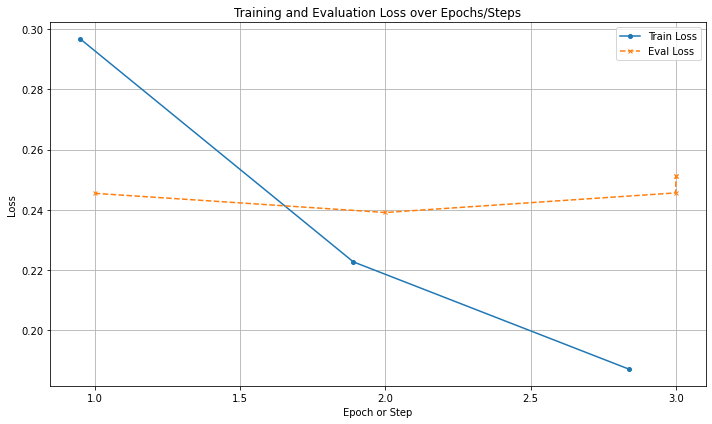

In [22]:
plot_loss_history(trainer.state.log_history)

배치사이즈를 크게 잡아 빠르게 과적합이 발생할 경향성을 보임

3에폭부터 평가로스가 소폭 상승함 

하지만 에폭수가 작아서 확실히 과적합이 발생한건가라는 생각도 듦


In [14]:
trainer.evaluate(hf_test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 256


{'eval_loss': 0.25120973587036133,
 'eval_accuracy': 0.90086,
 'eval_runtime': 180.2799,
 'eval_samples_per_second': 277.346,
 'eval_steps_per_second': 1.087,
 'epoch': 3.0}

| 항목                  | 값                                  |
| :-------------------- | :---------------------------------- |
| **최종 학습 손실 (Training Loss)** | 0.2326                              |
| **총 학습 시간 (Train Runtime)** | 4014.89 초 (1시간 6분)             |
| **학습 샘플/초 (Train Samples/sec)** | 100.874                             |
| **학습 스텝/초 (Train Steps/sec)** | 0.395                               |
| **총 FLOPs (Total FLOPs)** | 1.2487e+16                          |
| **총 에폭 (Total Epochs)** | 3.0                                 |
|                       |                                     |
| **에폭별 학습 성능** | **Training Loss** | **Validation Loss** | **Accuracy** |
| 에폭 1                | 0.2968            | 0.245483            | 0.897467     |
| 에폭 2                | 0.2227            | 0.239114            | 0.902267     |
| 에폭 3                | 0.1870            | 0.245629            | 0.904267     |
|                       |                                     |
| **최종 평가 성능** |                                     |
| **평가 손실 (Eval Loss)** | 0.2512                              |
| **평가 정확도 (Eval Accuracy)** | 0.90086                             |
| **평가 시간 (Eval Runtime)** | 180.28 초 (~3분)               |
| **평가 샘플/초 (Eval Samples/sec)** | 277.346                             |
| **평가 스텝/초 (Eval Steps/sec)** | 1.087                               |

최종정확도 90% 이상을 기록

## STEP 4. Fine-tuning을 통하여 모델 성능(accuarcy) 향상시키기
accuarcy 90%을 넘었으므로 통과

## STEP 5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교

In [12]:
import numpy as np

In [13]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [14]:
from transformers import Trainer, TrainingArguments
import os
output_dir = os.getenv('HOME')+'/aiffel/transformers'

training_arguments_with_bucketing = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 256,   # 각 device 당 batch size
    per_device_eval_batch_size = 256,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
    group_by_length=True # 버케팅 활성화
)

trainer_with_bucketing = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments_with_bucketing,        
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
    data_collator = data_collator, # 버케팅 추가
)

trainer_with_bucketing.train()


The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 135000
  Num Epochs = 3
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 1584


Epoch,Training Loss,Validation Loss,Accuracy
1,0.298900,0.247489,0.896667
2,0.223100,0.240610,0.901133
3,0.187600,0.247210,0.903067


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 256
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 256
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint

TrainOutput(global_step=1584, training_loss=0.23367260080395322, metrics={'train_runtime': 4016.0774, 'train_samples_per_second': 100.845, 'train_steps_per_second': 0.394, 'total_flos': 1.2487497354e+16, 'train_loss': 0.23367260080395322, 'epoch': 3.0})

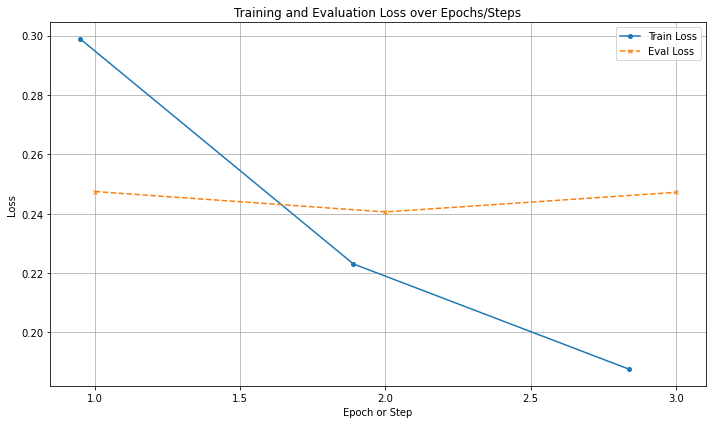

In [17]:
plot_loss_history(trainer_with_bucketing.state.log_history)

In [18]:
trainer_with_bucketing.evaluate(hf_test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 256


{'eval_loss': 0.2528436481952667,
 'eval_accuracy': 0.90062,
 'eval_runtime': 180.0556,
 'eval_samples_per_second': 277.692,
 'eval_steps_per_second': 1.089,
 'epoch': 3.0}

### 학습 성능 비교 (기존 vs. 동적 패딩)

| 항목                      | 값 (기존)                     | 값 (동적 패딩)                   |
| :------------------------ | :---------------------------- | :-------------------------------- |
| **최종 학습 손실 (Training Loss)** | 0.2326                        | 0.1876 (에폭 3)                 |
| **총 학습 시간 (Train Runtime)** | 4014.89 초 (1시간 6분 55초)        | **4016.0774 초 (1시간 6분 56초)** |
| **학습 샘플/초 (Train Samples/sec)** | 100.874                       | 100.845                         |
| **학습 스텝/초 (Train Steps/sec)** | 0.395                         | 0.394                           |
| **총 FLOPs (Total FLOPs)** | 1.2487e+16                    | 1.2487497354e+16                |
| **총 에폭 (Total Epochs)** | 3.0                           | 3.0                             |
| **에폭별 학습 성능** |                               |                                 |
| **에폭 1 - Training Loss** | 0.2968                        | 0.298900                        |
| **에폭 1 - Validation Loss** | 0.245483                      | 0.247489                        |
| **에폭 1 - Accuracy** | 0.897467                      | 0.896667                        |
| **에폭 2 - Training Loss** | 0.2227                        | 0.223100                        |
| **에폭 2 - Validation Loss** | 0.239114                      | 0.240610                        |
| **에폭 2 - Accuracy** | 0.902267                      | 0.901133                        |
| **에폭 3 - Training Loss** | 0.1870                        | 0.187600                        |
| **에폭 3 - Validation Loss** | 0.245629                      | 0.247210                        |
| **에폭 3 - Accuracy** | 0.904267                      | 0.903067                        |
| **최종 평가 성능** |                               |                                 |
| **평가 손실 (Eval Loss)** | 0.2512                        | 0.2528436481952667              |
| **평가 정확도 (Eval Accuracy)** | 0.90086                       | 0.90062                         |
| **평가 시간 (Eval Runtime)** | 180.28 초 (~3분)              | 180.0556                        |
| **평가 샘플/초 (Eval Samples/sec)** | 277.346                       | 277.692                         |
| **평가 스텝/초 (Eval Steps/sec)** | 1.087                         | 1.089                           |

전반적으로 정확도는 줄었고 학습시간은 1초 차이이지만 같다고 볼 수 있다.

기존의 동적패딩없이 학습을 진행했을 때 배치사이즈와 최대길이를 보수적으로 설정했기 때문에 

위와 같이 동적패딩의 효과를 크게 체감할 수 없었던 것 같다.

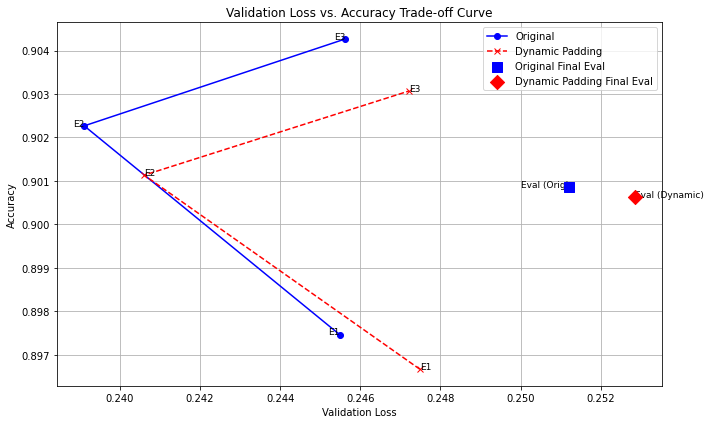

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for 'Original' model
original_data = {
    'Epoch': [1, 2, 3],
    'Validation Loss': [0.245483, 0.239114, 0.245629],
    'Accuracy': [0.897467, 0.902267, 0.904267]
}
df_original = pd.DataFrame(original_data)

# Data for 'Dynamic Padding' model
dynamic_padding_data = {
    'Epoch': [1, 2, 3],
    'Validation Loss': [0.247489, 0.240610, 0.247210],
    'Accuracy': [0.896667, 0.901133, 0.903067]
}
df_dynamic_padding = pd.DataFrame(dynamic_padding_data)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot for Original Model
plt.plot(df_original['Validation Loss'], df_original['Accuracy'],
         marker='o', linestyle='-', color='blue', label='Original')
for i, epoch in enumerate(df_original['Epoch']):
    plt.text(df_original['Validation Loss'][i], df_original['Accuracy'][i], f'E{epoch}', fontsize=9, ha='right')


# Plot for Dynamic Padding Model
plt.plot(df_dynamic_padding['Validation Loss'], df_dynamic_padding['Accuracy'],
         marker='x', linestyle='--', color='red', label='Dynamic Padding')
for i, epoch in enumerate(df_dynamic_padding['Epoch']):
    plt.text(df_dynamic_padding['Validation Loss'][i], df_dynamic_padding['Accuracy'][i], f'E{epoch}', fontsize=9, ha='left')

# Add final evaluation points
eval_loss_original = 0.2512
eval_accuracy_original = 0.90086
plt.scatter(eval_loss_original, eval_accuracy_original, color='blue', marker='s', s=100, zorder=5, label='Original Final Eval')
plt.text(eval_loss_original, eval_accuracy_original, 'Eval (Orig)', fontsize=9, ha='right')

eval_loss_dynamic = 0.2528436481952667
eval_accuracy_dynamic = 0.90062
plt.scatter(eval_loss_dynamic, eval_accuracy_dynamic, color='red', marker='D', s=100, zorder=5, label='Dynamic Padding Final Eval')
plt.text(eval_loss_dynamic, eval_accuracy_dynamic, 'Eval (Dynamic)', fontsize=9, ha='left')


# Add labels and title
plt.title('Validation Loss vs. Accuracy Trade-off Curve')
plt.xlabel('Validation Loss')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

전체적으로 겹쳐지있는 경향성을 보인다.

배치사이즈 크게, 최대길이 짧게 설정했을 때는 트레이드-오프 관계에서 유의미한 변화가 없음을 알 수 있었다.

# 회고

배치사이즈와 동적패딩의 의미에 대해 팀원들과 이야기하면서 트레이드-오프 관계가 왜 발생하는지를 정확하게 이해할 수 있게 되어
만족스러웠다.

또한 기존에 레이어층을 직접 쌓다가 허깅페이스를 통해 딸깍하는 경험은 정말 신세계였습니다.

이런 편한툴이 있고 고통은 잠시이니 쫌 더 바닥부터 모델설계에 대한 동기부여가 된 것 같습니다.